**Imports and data loading**


Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [36]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Load dataset into dataframe
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from previous course
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

In [5]:
# Inspect the first few rows of df0
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [6]:
# Inspect the first few rows of `nyc_preds_means`
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


In [7]:
# Merge datasets
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)

df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


**Feature engineering**



In [8]:
# Call info() on the dataframe.
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20689 entries, 0 to 20688
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             20689 non-null  int64  
 1   VendorID               20689 non-null  int64  
 2   tpep_pickup_datetime   20689 non-null  object 
 3   tpep_dropoff_datetime  20689 non-null  object 
 4   passenger_count        20689 non-null  int64  
 5   trip_distance          20689 non-null  float64
 6   RatecodeID             20689 non-null  int64  
 7   store_and_fwd_flag     20689 non-null  object 
 8   PULocationID           20689 non-null  int64  
 9   DOLocationID           20689 non-null  int64  
 10  payment_type           20689 non-null  int64  
 11  fare_amount            20689 non-null  float64
 12  extra                  20689 non-null  float64
 13  mta_tax                20689 non-null  float64
 14  tip_amount             20689 non-null  float64
 15  tolls_a

In [9]:
# Subset the data to isolate only customers who paid by credit card
df1 = df0[df0['payment_type']==1]

##### **Target**

Notice that there isn't a column that indicates tip percent, which is what you need to create the target variable. You'll have to engineer it.

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

Round the result to three places beyond the decimal. **This is an important step.** It affects how many customers are labeled as generous tippers. In fact, without performing this step, approximately 1,800 people who do tip ≥ 20% would be labeled as not generous.

To understand why, you must consider how floats work. Computers make their calculations using floating-point arithmetic (hence the word "float"). Floating-point arithmetic is a system that allows computers to express both very large numbers and very small numbers with a high degree of precision, encoded in binary. However, precision is limited by the number of bits used to represent a number, which is generally 32 or 64, depending on the capabilities of your operating system.

This comes with limitations in that sometimes calculations that should result in clean, precise values end up being encoded as very long decimals. Take, for example, the following calculation:


In [10]:
# Create tip % col
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)

/tmp/ipython-input-1025802444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)


Now create another column called generous. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

Begin by making the generous column a copy of the tip_percent column.
Reassign the column by converting it to Boolean (True/False).
Reassign the column by converting Boolean to binary (1/0).

In [11]:
# Create 'generous' col (target)
df1['generous'] = df1['tip_percent']
df1['generous'] = (df1['generous'] >= 0.2)
df1['generous'] = df1['generous'].astype(int)

/tmp/ipython-input-53023181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['generous'] = df1['tip_percent']
/tmp/ipython-input-53023181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['generous'] = (df1['generous'] >= 0.2)
/tmp/ipython-input-53023181.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [12]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

/tmp/ipython-input-3830057672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
/tmp/ipython-input-3830057672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')


In [13]:
# Create a 'day' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

/tmp/ipython-input-918047604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()


Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [14]:
# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

/tmp/ipython-input-986325379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour
/tmp/ipython-input-986325379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour
/tmp/ipython-input-986325379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [15]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [16]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head()

/tmp/ipython-input-227023620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['am_rush'] = df1.apply(am_rush, axis=1)


,am_rush
0,1
1,0
2,1
3,0
5,0


In [17]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [18]:
# Apply 'daytime' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)

/tmp/ipython-input-1985778239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['daytime'] = df1.apply(daytime, axis=1)


In [19]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [20]:
# Apply 'pm_rush' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

/tmp/ipython-input-3651034778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pm_rush'] = df1.apply(pm_rush, axis=1)


In [21]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [22]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1.apply(nighttime, axis=1)

/tmp/ipython-input-230608774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['nighttime'] = df1.apply(nighttime, axis=1)


In [23]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

/tmp/ipython-input-2202272965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()


In [24]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,0,0,1,mar


In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13901 entries, 0 to 20688
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             13901 non-null  int64         
 1   VendorID               13901 non-null  int64         
 2   tpep_pickup_datetime   13901 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  13901 non-null  datetime64[ns]
 4   passenger_count        13901 non-null  int64         
 5   trip_distance          13901 non-null  float64       
 6   RatecodeID             13901 non-null  int64         
 7   store_and_fwd_flag     13901 non-null  object        
 8   PULocationID           13901 non-null  int64         
 9   DOLocationID           13901 non-null  int64         
 10  payment_type           13901 non-null  int64         
 11  fare_amount            13901 non-null  float64       
 12  extra                  13901 non-null  float64       
 13  mta_ta

In [26]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13901 entries, 0 to 20688
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         13901 non-null  int64  
 1   passenger_count  13901 non-null  int64  
 2   RatecodeID       13901 non-null  int64  
 3   PULocationID     13901 non-null  int64  
 4   DOLocationID     13901 non-null  int64  
 5   mean_duration    13901 non-null  float64
 6   mean_distance    13901 non-null  float64
 7   predicted_fare   13901 non-null  float64
 8   generous         13901 non-null  int64  
 9   day              13901 non-null  object 
 10  am_rush          13901 non-null  int64  
 11  daytime          13901 non-null  int64  
 12  pm_rush          13901 non-null  int64  
 13  nighttime        13901 non-null  int64  
 14  month            13901 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.7+ MB


## Variable encoding


Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`.

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.


In [27]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

In [28]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13901 entries, 0 to 20688
Columns: 343 entries, passenger_count to month_sep
dtypes: bool(334), float64(3), int64(6)
memory usage: 5.5 MB


# **Evaluation metric**


Before modeling, you must decide on an evaluation metric.

Examine the class balance of your target variable.

In [29]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

,proportion
generous,
1,0.525286
0,0.474714


A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**The stakes are relatively even. we want to help taxi drivers make more money, but we don't want this to anger customers. Our metric should weigh both precision and recall equally. Which metric is this?**

**used matrice:**  F<sub>1</sub> score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.

# **Modeling**


##### **Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/testing data.

1. Define a variable `y` that isolates the target variable (`generous`).
2. Define a variable `X` that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [35]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [37]:
# 1. Instantiate the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# 2. Define a reduced parameter grid for randomized search
cv_params = {
    'max_depth': [None, 15, 30],          # fewer depth options
    'max_features': [0.7, 1.0],           # fewer feature options
    'max_samples': [0.7, 1.0],            # fewer sample options
    'min_samples_leaf': [1, 2],           # reduced options
    'min_samples_split': [2, 5],          # reduced options
    'n_estimators': [100, 200, 300]       # still try small-medium-large forests
}

# 3. Define the scoring metric list
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Use RandomizedSearchCV for faster tuning
rf1 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=cv_params,
    n_iter=30,            # test 30 random combinations instead of 972
    scoring=scoring,
    refit='f1',           # best model based on F1-score
    cv=4,
    n_jobs=-1,            # use all CPU cores
    verbose=2,
    random_state=42
)

In [38]:
%%time
rf1.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
CPU times: user 14.4 s, sys: 1.68 s, total: 16 s
Wall time: 25min 57s


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [None, 15, 30],
                                        'max_features': [0.7, 1.0],
                                        'max_samples': [0.7, 1.0],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'],
                   verbose=2)

In [61]:
import pickle
import os

# Define path (use raw string for Windows paths)
path = r'/content/drive/MyDrive/Untitled Folder'

def write_pickle(path, model_object, save_name: str):
    """
    Save a Python object (model) as a pickle file.
    """
    file_path = os.path.join(path, save_name + '.pickle')
    with open(file_path, 'wb') as to_write:
        pickle.dump(model_object, to_write)
    print(f"Model saved at: {file_path}")

def read_pickle(path, saved_model_name: str):
    """
    Load a pickled model from the given path.
    """
    file_path = os.path.join(path, saved_model_name + '.pickle')
    with open(file_path, 'rb') as to_read:
        model = pickle.load(to_read)
    return model


In [62]:
# Save your trained model
write_pickle(path, rf1, 'rf_best_model')

# Load it back later
loaded_model = read_pickle(path, 'rf_best_model')

# Verify it works
print(loaded_model.best_score_)


Model saved at: /content/drive/MyDrive/Untitled Folder/rf_best_model.pickle
0.7437910564639643


In [46]:
# Examine best score
rf1.best_score_

np.float64(0.7437910564639643)

In [47]:
rf1.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_samples': 0.7,
 'max_features': 0.7,
 'max_depth': 15}

In [48]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [49]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.690894,0.805682,0.743791,0.708453


In [60]:
import os
path = '/content/drive/MyDrive/Untitled Folder' # Make sure this matches the path in your save/load cell
os.makedirs(path, exist_ok=True)

In [64]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

In [65]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [66]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.690894,0.805682,0.743791,0.708453
0,RF test,0.678346,0.808350,0.737664,0.697950


***XG BOOST***

In [69]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1. Instantiate the XGBoost classifier with parallelism
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=0,
    n_jobs=-1,           # Use all CPU cores for speed
    eval_metric='logloss'
)

# 2. Define a smaller but effective hyperparameter search space
cv_params = {
    'learning_rate': [0.01, 0.05, 0.1],     # lower rates for better generalization
    'max_depth': [4, 6, 8],                 # reasonable depth
    'min_child_weight': [1, 2, 5],          # prevent overfitting
    'n_estimators': [100, 200, 300, 500],   # smaller ranges than 500 fixed
    'subsample': [0.7, 0.9, 1.0],           # row sampling
    'colsample_bytree': [0.7, 0.9, 1.0]     # feature sampling
}

# 3. Define scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Use RandomizedSearchCV for faster hyperparameter tuning
xgb1 = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=cv_params,
    n_iter=30,           # Try 30 random combinations instead of all
    scoring=scoring,
    refit='f1',
    cv=4,
    n_jobs=-1,           # Parallelize CV
    verbose=2,
    random_state=42
)

In [70]:
%%time
xgb1.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
CPU times: user 4.41 s, sys: 219 ms, total: 4.63 s
Wall time: 2min 51s


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8],
                                        'min_child_weight': [1, 2, 5],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.7, 0.9, 1.0]},
                   random_state=42, refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'],
                   verbose=2)

In [71]:
# Examine best score
xgb1.best_score_

np.float64(0.7480827195982955)

In [72]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.690894,0.805682,0.743791,0.708453
0,RF test,0.678346,0.808350,0.737664,0.697950
0,XGB CV,0.693823,0.811675,0.748083,0.712860


In [73]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

In [74]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.690894,0.805682,0.743791,0.708453
0,RF test,0.678346,0.808350,0.737664,0.697950
0,XGB CV,0.693823,0.811675,0.748083,0.712860
0,XGB test,0.682184,0.812457,0.741643,0.702625


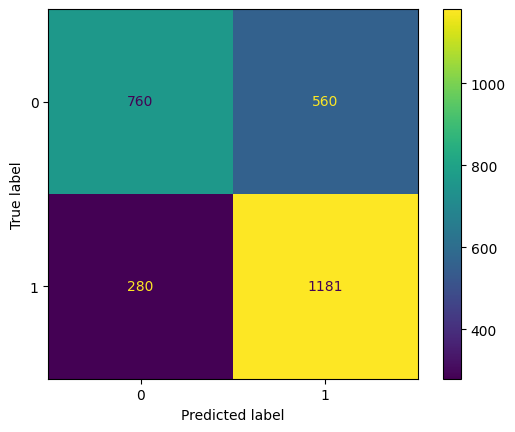

In [75]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_,
                             )
disp.plot(values_format='');

The model is almost twice as likely to predict a false positive than it is to predict a false negative. Therefore, type I errors are more common. This is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory.

##### Feature importance

Use the `feature_importances_` attribute of the best estimator object to inspect the features of your final model. You can then sort them and plot the most important ones

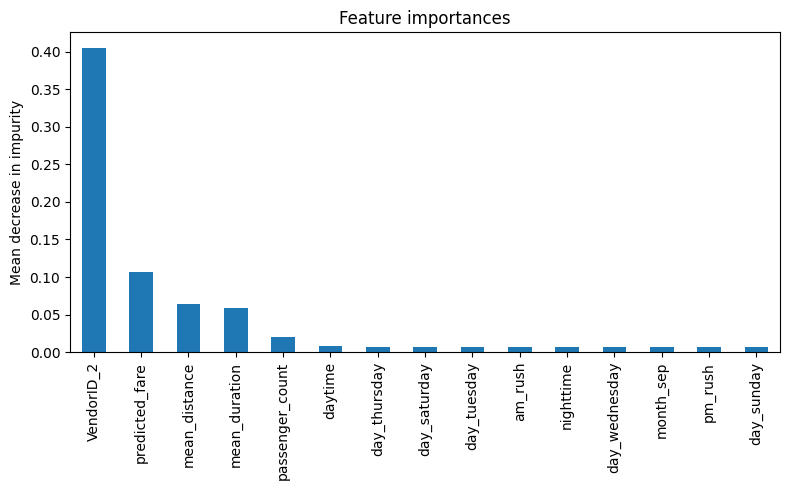

In [76]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();